# Score Matching for Tabular Data Generation

This notebook demonstrates the basic concepts of score matching and how to use it to generate synthetic tabular data with mixed types (numerical and categorical features).

## What is Score Matching?

Score matching is a technique for learning probability distributions by matching the **score function** (gradient of log probability) rather than the probability itself. The score function is:

$$\nabla_x \log p(x)$$

Key advantages:
- No need to compute intractable normalization constants
- Works well for complex, high-dimensional distributions
- Foundation for diffusion models and score-based generative models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

## Step 1: Create a Synthetic Mixed-Type Dataset

We'll create a simple dataset with:
- 2 numerical features (age, income)
- 2 categorical features (education, occupation)

In [2]:
# Generate synthetic data
n_samples = 1000

# Numerical features
age = np.random.normal(35, 10, n_samples)
age = np.clip(age, 18, 65)

# Income correlates with age
income = 30000 + age * 1000 + np.random.normal(0, 10000, n_samples)
income = np.clip(income, 20000, 150000)

# Categorical features
education = np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], 
                            n_samples, p=[0.3, 0.4, 0.2, 0.1])
occupation = np.random.choice(['Engineer', 'Teacher', 'Doctor', 'Artist'], 
                             n_samples, p=[0.35, 0.25, 0.25, 0.15])

# Create DataFrame
df = pd.DataFrame({
    'age': age,
    'income': income,
    'education': education,
    'occupation': occupation
})

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset statistics:")
print(df.describe())

Dataset shape: (1000, 4)

First few rows:
         age        income    education occupation
0  39.967142  83960.695896     Bachelor   Engineer
1  33.617357  72863.693817  High School    Teacher
2  41.476885  72073.189080     Bachelor     Doctor
3  50.230299  73760.930787  High School   Engineer
4  32.658466  69640.699389       Master    Teacher

Dataset statistics:
               age         income
count  1000.000000    1000.000000
mean     35.310670   66019.032467
std       9.487970   13484.533080
min      18.000000   24979.945236
25%      28.524097   57773.412095
50%      35.253006   65428.021694
75%      41.479439   74430.262680
max      65.000000  112495.767432


## Step 2: Preprocess the Data

We'll normalize numerical features and one-hot encode categorical features.

In [3]:
# Separate numerical and categorical columns
numerical_cols = ['age', 'income']
categorical_cols = ['education', 'occupation']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(sparse_output=False), categorical_cols)
    ])

# Fit and transform
X_processed = preprocessor.fit_transform(df)

# Get feature names after preprocessing
num_features = numerical_cols
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_features = list(num_features) + list(cat_features)

print(f"Original features: {len(df.columns)}")
print(f"Processed features: {X_processed.shape[1]}")
print(f"\nFeature names: {all_features}")

# Convert to PyTorch tensor
X_tensor = torch.FloatTensor(X_processed)

Original features: 4
Processed features: 10

Feature names: ['age', 'income', 'education_Bachelor', 'education_High School', 'education_Master', 'education_PhD', 'occupation_Artist', 'occupation_Doctor', 'occupation_Engineer', 'occupation_Teacher']


## Step 3: Define the Score Network

This neural network learns to predict the score function $\nabla_x \log p(x)$ at any point $x$.

In score-based generative models, we also add noise at different levels and learn the score at each noise level.

In [4]:
class ScoreNetwork(nn.Module):
    """Neural network that predicts the score function."""
    
    def __init__(self, input_dim, hidden_dim=128):
        super(ScoreNetwork, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),  # +1 for noise level
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)  # Output: score for each dimension
        )
    
    def forward(self, x, sigma):
        """
        Args:
            x: input data [batch_size, input_dim]
            sigma: noise level [batch_size, 1]
        Returns:
            score: predicted score [batch_size, input_dim]
        """
        # Concatenate input with noise level
        x_sigma = torch.cat([x, sigma], dim=-1)
        return self.network(x_sigma)

# Initialize the model
input_dim = X_tensor.shape[1]
score_model = ScoreNetwork(input_dim, hidden_dim=128)
print(f"Score network initialized with input dimension: {input_dim}")
print(f"Total parameters: {sum(p.numel() for p in score_model.parameters())}")

Score network initialized with input dimension: 10
Total parameters: 35850


## Step 4: Implement Denoising Score Matching Loss

The denoising score matching objective is:

$$\mathcal{L} = \mathbb{E}_{x, \epsilon, \sigma} \left[ \lambda(\sigma) \left\| s_\theta(x + \sigma \epsilon, \sigma) + \frac{\epsilon}{\sigma} \right\|^2 \right]$$

Where:
- $x$ is the clean data
- $\epsilon \sim \mathcal{N}(0, I)$ is Gaussian noise
- $\sigma$ is the noise level
- $s_\theta$ is our score network
- The true score of the noisy distribution is $-\epsilon/\sigma$

In [5]:
def denoising_score_matching_loss(score_model, x, sigma_levels):
    """
    Compute denoising score matching loss.
    
    Args:
        score_model: the score network
        x: clean data [batch_size, input_dim]
        sigma_levels: list of noise levels to train on
    """
    batch_size = x.shape[0]
    
    # Randomly sample noise level for each sample
    sigma_idx = torch.randint(0, len(sigma_levels), (batch_size,))
    sigma = torch.FloatTensor([sigma_levels[i] for i in sigma_idx]).view(-1, 1)
    
    # Sample Gaussian noise
    epsilon = torch.randn_like(x)
    
    # Add noise to data
    x_noisy = x + sigma * epsilon
    
    # Predict score
    predicted_score = score_model(x_noisy, sigma)
    
    # True score is -epsilon/sigma
    true_score = -epsilon / sigma
    
    # MSE loss
    loss = torch.mean(torch.sum((predicted_score - true_score) ** 2, dim=-1))
    
    return loss

# Define noise levels (geometric progression)
sigma_levels = np.exp(np.linspace(np.log(0.01), np.log(1.0), 10))
print(f"Training with {len(sigma_levels)} noise levels: {sigma_levels}")

Training with 10 noise levels: [0.01       0.01668101 0.02782559 0.04641589 0.07742637 0.12915497
 0.21544347 0.35938137 0.59948425 1.        ]


## Step 5: Train the Score Model

We'll train the network to predict scores at various noise levels.

Epoch 10/100, Loss: 16333.9965
Epoch 20/100, Loss: 14496.3923
Epoch 30/100, Loss: 14578.3782
Epoch 40/100, Loss: 16393.7711
Epoch 50/100, Loss: 15592.6661
Epoch 60/100, Loss: 14831.4659
Epoch 70/100, Loss: 14689.5345
Epoch 80/100, Loss: 15085.0164
Epoch 90/100, Loss: 17123.0387
Epoch 100/100, Loss: 13649.0486


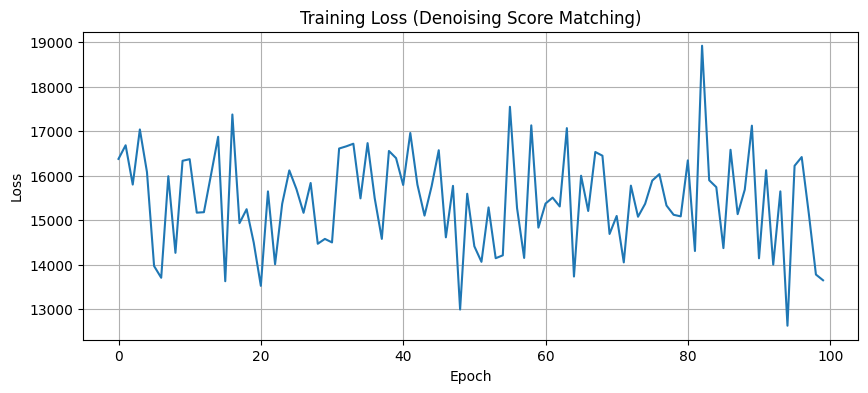


Training completed!


In [6]:
# Training setup
optimizer = optim.Adam(score_model.parameters(), lr=0.001)
batch_size = 128
n_epochs = 100

# Create data loader
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
losses = []
score_model.train()

for epoch in range(n_epochs):
    epoch_losses = []
    
    for batch_idx, (batch_x,) in enumerate(dataloader):
        optimizer.zero_grad()
        
        # Compute loss
        loss = denoising_score_matching_loss(score_model, batch_x, sigma_levels)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
    
    avg_loss = np.mean(epoch_losses)
    losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (Denoising Score Matching)')
plt.grid(True)
plt.show()

print("\nTraining completed!")

## Step 6: Generate New Samples using Langevin Dynamics

To generate samples, we use **annealed Langevin dynamics**:

1. Start with random noise
2. For each noise level (from high to low):
   - Run Langevin MCMC steps: $x_{t+1} = x_t + \epsilon \cdot s_\theta(x_t, \sigma) + \sqrt{2\epsilon} \cdot z$
   - where $z \sim \mathcal{N}(0, I)$
3. Final samples approximate the data distribution

In [8]:
def generate_samples(score_model, n_samples, input_dim, sigma_levels, n_steps_per_sigma=100):
    """
    Generate samples using annealed Langevin dynamics.
    
    Args:
        score_model: trained score network
        n_samples: number of samples to generate
        input_dim: dimension of the data
        sigma_levels: noise levels (should be in descending order)
        n_steps_per_sigma: number of Langevin steps per noise level
    """
    score_model.eval()
    
    # Start with random noise
    x = torch.randn(n_samples, input_dim)
    
    # Reverse the sigma levels (high to low)
    sigma_levels_reversed = sorted(sigma_levels, reverse=True)
    
    with torch.no_grad():
        for sigma in sigma_levels_reversed:
            # Step size for Langevin dynamics - convert to tensor
            step_size = torch.tensor(0.01 * (sigma ** 2))
            
            for step in range(n_steps_per_sigma):
                # Get score estimate
                sigma_tensor = torch.ones(n_samples, 1) * sigma
                score = score_model(x, sigma_tensor)
                
                # Langevin dynamics update
                noise = torch.randn_like(x)
                x = x + step_size * score + torch.sqrt(2 * step_size) * noise
    
    return x.numpy()

# Generate new samples
print("Generating 500 new samples...")
generated_samples = generate_samples(
    score_model, 
    n_samples=500, 
    input_dim=input_dim,
    sigma_levels=sigma_levels,
    n_steps_per_sigma=50
)

print(f"Generated samples shape: {generated_samples.shape}")

Generating 500 new samples...
Generated samples shape: (500, 10)


## Step 7: Post-process and Visualize Generated Data

We need to inverse transform the generated data back to the original scale.

In [10]:
# Custom inverse transformation function
def inverse_transform_data(processed_data, preprocessor, numerical_cols, categorical_cols):
    """
    Inverse transform the processed data back to original format.
    """
    # Get the transformers
    num_transformer = preprocessor.named_transformers_['num']  # StandardScaler
    cat_transformer = preprocessor.named_transformers_['cat']  # OneHotEncoder
    
    # Get the number of numerical and categorical features
    n_numerical = len(numerical_cols)
    n_categorical = processed_data.shape[1] - n_numerical
    
    # Split the processed data
    numerical_data = processed_data[:, :n_numerical]
    categorical_data = processed_data[:, n_numerical:]
    
    # Inverse transform numerical data
    numerical_inverse = num_transformer.inverse_transform(numerical_data)
    
    # Inverse transform categorical data
    categorical_inverse = cat_transformer.inverse_transform(categorical_data)
    
    # Combine the results
    result = np.column_stack([numerical_inverse, categorical_inverse])
    
    return result

# Inverse transform to get back to original scale
generated_data_inverse = inverse_transform_data(
    generated_samples, 
    preprocessor, 
    numerical_cols, 
    categorical_cols
)

# Create DataFrame
generated_df = pd.DataFrame(generated_data_inverse, columns=['age', 'income', 'education', 'occupation'])

# Clean up numerical values
generated_df['age'] = generated_df['age'].clip(18, 65)
generated_df['income'] = generated_df['income'].clip(20000, 150000)

print("Generated data (first 10 rows):")
print(generated_df.head(10))
print("\nGenerated data statistics:")
print(generated_df.describe())

Generated data (first 10 rows):
         age        income    education occupation
0  51.741043  98989.164062       Master     Artist
1  31.013708  64679.609375       Master     Artist
2  52.220047  79325.804688       Master   Engineer
3  35.256889  79191.453125       Master     Artist
4         18  57350.789062  High School   Engineer
5   21.44042  44280.128906          PhD     Artist
6  61.826984  97481.007812       Master     Artist
7         18  64840.441406  High School    Teacher
8  18.936878    67499.8125       Master    Teacher
9  45.748463  91694.632812     Bachelor   Engineer

Generated data statistics:
        age  income education occupation
count   500     500       500        500
unique  434     495         4          4
top      18   20000    Master   Engineer
freq     56       6       206        190


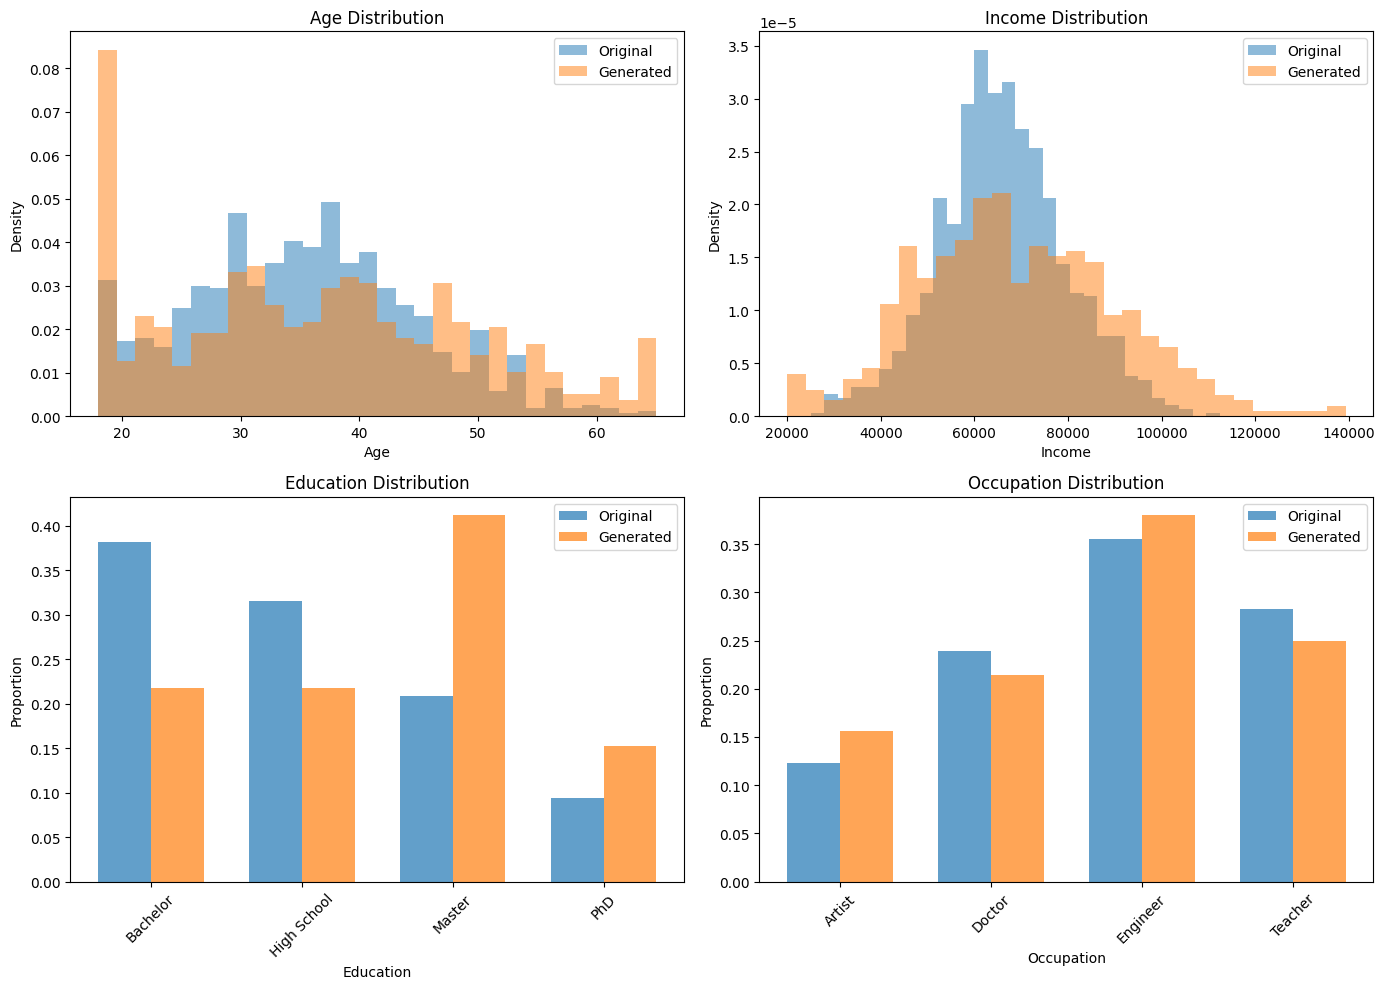

In [11]:
# Visualize original vs generated data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution
axes[0, 0].hist(df['age'], bins=30, alpha=0.5, label='Original', density=True)
axes[0, 0].hist(generated_df['age'], bins=30, alpha=0.5, label='Generated', density=True)
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].legend()

# Income distribution
axes[0, 1].hist(df['income'], bins=30, alpha=0.5, label='Original', density=True)
axes[0, 1].hist(generated_df['income'], bins=30, alpha=0.5, label='Generated', density=True)
axes[0, 1].set_xlabel('Income')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Income Distribution')
axes[0, 1].legend()

# Education distribution
edu_orig = df['education'].value_counts(normalize=True).sort_index()
edu_gen = generated_df['education'].value_counts(normalize=True).sort_index()
x = np.arange(len(edu_orig))
width = 0.35
axes[1, 0].bar(x - width/2, edu_orig.values, width, alpha=0.7, label='Original')
axes[1, 0].bar(x + width/2, edu_gen.values, width, alpha=0.7, label='Generated')
axes[1, 0].set_xlabel('Education')
axes[1, 0].set_ylabel('Proportion')
axes[1, 0].set_title('Education Distribution')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(edu_orig.index, rotation=45)
axes[1, 0].legend()

# Occupation distribution
occ_orig = df['occupation'].value_counts(normalize=True).sort_index()
occ_gen = generated_df['occupation'].value_counts(normalize=True).sort_index()
x = np.arange(len(occ_orig))
axes[1, 1].bar(x - width/2, occ_orig.values, width, alpha=0.7, label='Original')
axes[1, 1].bar(x + width/2, occ_gen.values, width, alpha=0.7, label='Generated')
axes[1, 1].set_xlabel('Occupation')
axes[1, 1].set_ylabel('Proportion')
axes[1, 1].set_title('Occupation Distribution')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(occ_orig.index, rotation=45)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

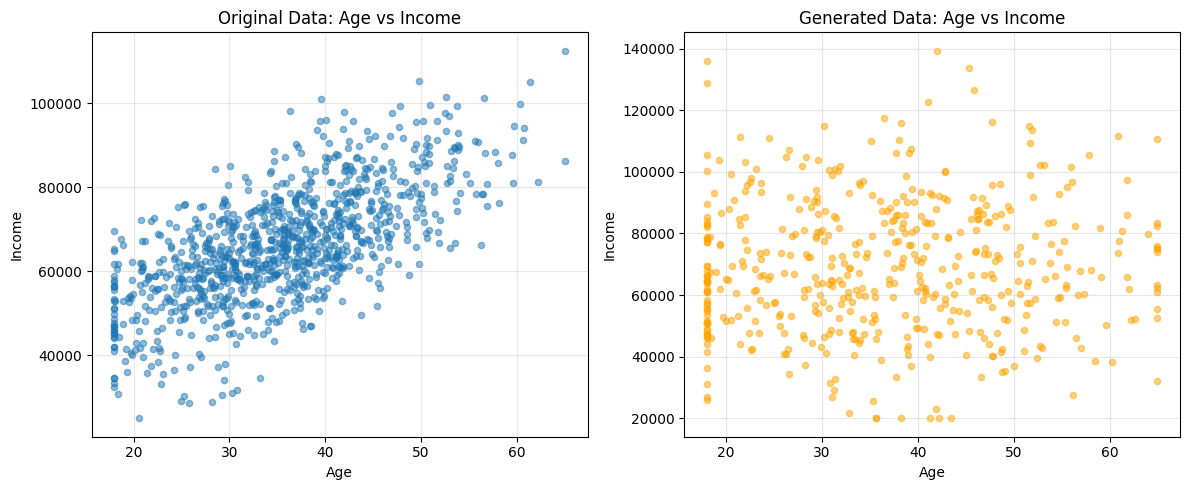

In [12]:
# Scatter plot: Age vs Income (shows correlation preservation)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df['age'], df['income'], alpha=0.5, s=20)
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Original Data: Age vs Income')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(generated_df['age'], generated_df['income'], alpha=0.5, s=20, color='orange')
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Generated Data: Age vs Income')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

### Key Concepts Demonstrated:

1. **Score Matching**: We trained a neural network to estimate the score function (gradient of log probability) instead of the probability itself.

2. **Denoising Score Matching**: By adding noise at different levels and learning to denoise, we avoid computing intractable gradients of the data distribution.

3. **Multi-scale Noise**: Using multiple noise levels helps the model learn both coarse and fine-grained features of the distribution.

4. **Langevin Dynamics**: We generated new samples by starting from noise and iteratively following the learned score function, gradually reducing noise.

5. **Mixed Data Types**: The approach handles both numerical and categorical features through appropriate preprocessing.

### Advantages:
- No need for adversarial training (unlike GANs)
- More stable training
- Can model complex distributions
- Generates diverse samples

### Practical Notes:
- For real applications, you'd want more sophisticated architectures (e.g., transformers for tabular data)
- More training epochs and careful hyperparameter tuning
- Better handling of categorical variables (e.g., using embeddings)
- Post-processing to ensure realistic categorical assignments